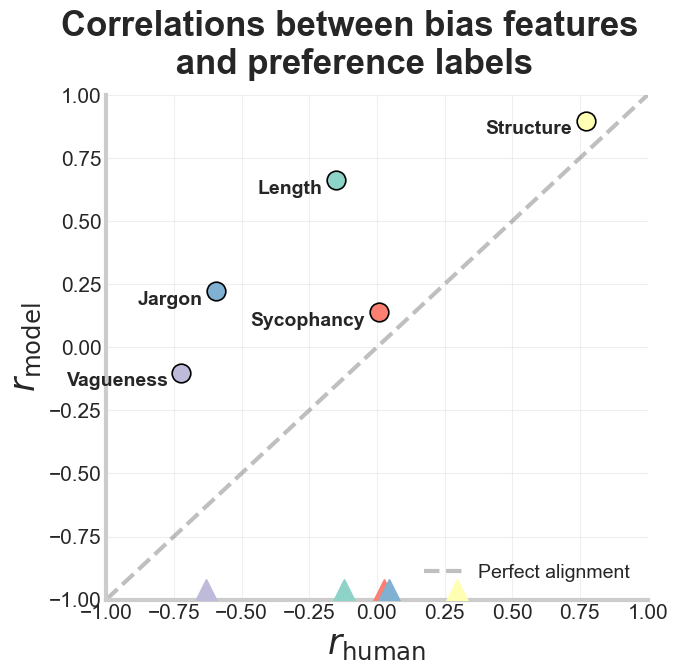

In [7]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, pearsonr

# ─── Style settings ──────────────────────────────────────────────
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 20,
    "axes.titlepad": 15,
})
cmap = plt.get_cmap("Set3")

# ─── Seeds ──────────────────────────────────────────────────────
random.seed(0)
np.random.seed(0)

# ─── I/O helpers ─────────────────────────────────────────────────
def read_jsonl(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f if line.strip()]

def read_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

# ─── Feature extractors ─────────────────────────────────────────
def feat_length(s):
    return len(s.split())

def has_structure(s):
    return int(any(l.strip().startswith(("-", "1.")) for l in s.splitlines()))

def has_vagueness(s):
    return int(s.count(";") >= 1 or s.count(",") >= 2)

def has_sycophancy(s):
    kws = ["you're right", "i agree", "good point", "exactly"]
    return int(any(p in s.lower() for p in kws))

def has_jargon(s):
    terms = {"algorithm", "model", "tensor", "epoch", "gradient"}
    return int(any(t in s.lower().split() for t in terms))

# ─── Bias settings ───────────────────────────────────────────────
bias_info = {
    "Length":    (None,            feat_length,   False),
    "Structure": ("chosen_list",   has_structure, True),
    "Vagueness": ("chosen_vagueness", has_vagueness, True),
    "Sycophancy":("chosen_sycophantic", has_sycophancy, True),
    "Jargon":    ("chosen_jargon", has_jargon,     True),
}

# mapping to the “which response has more bias?” field in your grouped JSON
more_key_map = {
    "Length":    "longer_response",
    "Structure": "more_structured_response",
    "Vagueness": "more_vague_response",
    "Sycophancy":"more_sycophantic_response",
    "Jargon":    "more_jargony_response",
}

# ─── Load training‐set data ─────────────────────────────────────
MAX_H = 2500
human           = read_jsonl("../../../data/skywork_training_sample.jsonl")[:MAX_H]
structure_lbls  = read_jsonl("../../../data/reward_model_training_labeled_data/skywork_sample_labeled_structure.jsonl")[:MAX_H]
vague_lbls      = read_jsonl("../../../data/reward_model_training_labeled_data/skywork_sample_labeled_vagueness.jsonl")[:MAX_H]
syco_lbls       = read_jsonl("../../../data/reward_model_training_labeled_data/skywork_sample_labeled_sycophancy.jsonl")[:MAX_H]
jargon_lbls     = read_jsonl("../../../data/reward_model_training_labeled_data/skywork_sample_labeled_jargon.jsonl")[:MAX_H]

assert len(human) == len(structure_lbls) == len(vague_lbls) == len(syco_lbls) == len(jargon_lbls)

# ─── Utility: correlation selector ───────────────────────────────
def corr_fn(is_binary):
    return pointbiserialr if is_binary else pearsonr

# ─── Collect results ────────────────────────────────────────────
results = []
for bias, (lbl_key, extractor, is_binary) in bias_info.items():
    # 1) human correlation on training set
    swap_h = set(random.sample(range(len(human)), k=len(human)//2))
    delta_h, pref_h = [], []
    lbls_map = {
        "Structure": structure_lbls,
        "Vagueness": vague_lbls,
        "Sycophancy": syco_lbls,
        "Jargon":    jargon_lbls
    }
    for i, h in enumerate(human):
        if lbl_key:
            has1 = int(lbls_map[bias][i][lbl_key].lower() == "yes")
            has2 = int(lbls_map[bias][i][lbl_key.replace("chosen","rejected")].lower() == "yes")
            d = has1 - has2
        else:
            d = extractor(h["chosen"]) - extractor(h["rejected"])
        p = 1
        if i in swap_h:
            d, p = -d, 0
        delta_h.append(d)
        pref_h.append(p)
    r_h, p_h = corr_fn(is_binary)(pref_h, delta_h)

    # 2) human & model on grouped (perturbation) data
    grouped = read_json(f"../../../human_annotation_data/{bias.lower()}/{bias.lower()}_grouped_human_annotations.json")
    delta_p, pref_hp, pref_mp = [], [], []
    for rec in grouped:
        # skip ties in human judgments
        if rec["most_frequent_preference"] == "Tie":
            continue
        # Δf: which response has the bias?
        if bias == "Length":
            d = extractor(rec["response_1"]) - extractor(rec["response_2"])
        else:
            more = rec[more_key_map[bias]]
            d = 1 if more == "response_1" else -1

        pref_hp.append(1 if rec["most_frequent_preference"] == "response_1" else 0)
        pref_mp.append(1 if rec["reward_model_preferred_response"] == "response_1" else 0)
        delta_p.append(d)

    r_h_pert, p_h_pert = corr_fn(is_binary)(pref_hp, delta_p)
    r_m,     p_m     = corr_fn(is_binary)(pref_mp, delta_p)

    results.append({
        "Bias":         bias,
        "r_h_train":    r_h,      "p_h_train":   p_h,
        "r_h_pert":     r_h_pert, "p_h_pert":    p_h_pert,
        "r_model":      r_m,      "p_model":     p_m,
        "Δr (model–train)": r_m - r_h
    })

df = pd.DataFrame(results).round(3)


# ─── Plot ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 7))
fig.subplots_adjust(right=0.75)

colors = dict(zip(df.Bias, cmap.colors[:len(df)]))

# first do the scatter + annotates as before
for _, row in df.iterrows():
    ax.scatter(
        row.r_h_pert,
        row.r_model,
        s=180,
        color=colors[row.Bias],
        edgecolor="black",
        linewidth=1.2,
        zorder=3
    )
    ax.annotate(
        row.Bias,
        (row.r_h_pert, row.r_model),
        textcoords="offset points",
        xytext=(-10, -10),
        ha="right",
        fontsize=14,
        weight="bold"
    )

# plot the perfect‐alignment line as before
ax.plot(
    [-1, 1], [-1, 1],
    linestyle="--",
    color="gray",
    linewidth=3,
    alpha=0.5,
    label="Perfect alignment",
    zorder=2,
)

# set the limits (this fixes ymin for the triangles)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# now add triangles at the bottom for each training‐set human correlation
ymin, _ = ax.get_ylim()
for bias, row in df.set_index("Bias").iterrows():
    ax.plot(
        row.r_h_train,
        ymin,
        marker="^",
        markersize=30,
        color=colors[bias],
        linestyle="",
        zorder=4
    )

# legend, labels, title, styling as before
ax.legend(loc="lower right", frameon=False, fontsize=14)
ax.set_xlabel(r"$r_{\mathrm{human}}$", fontsize=25)
ax.set_ylabel(r"$r_{\mathrm{model}}$", fontsize=25)
ax.set_title(
    "Correlations between bias features\n and preference labels",
    fontweight="bold",
    fontsize=25,
    x=0.45
)

for side in ["top", "right"]:
    ax.spines[side].set_visible(False)
ax.spines["left"].set_linewidth(3)
ax.spines["bottom"].set_linewidth(3)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("bias_correlation_with_triangles.pdf", dpi=300)
plt.show()


In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

DATA_DIR = Path("../../../data/reward_model_training_labeled_data/")
OUT_FIG  = Path("all_biases_matrix.pdf")

# 1) Build a dict: bias_name → file path
bias_files = {
    f.stem.split("_")[-1]: f
    for f in DATA_DIR.glob("*.jsonl")
    if f.stem.split("_")[-1] not in ("old", "elaboration")
}

# 2) Define the exact order you want (including "length" which isn’t in the dict)
bias_order = ["length", "structure", "jargon", "vagueness", "sycophancy"]

# 3) Create your 1×5 axes
fig, axes = plt.subplots(
    nrows=1, ncols=len(bias_order),
    figsize=(len(bias_order)*2.5, 4),
    sharey=True,
)

for ax, bias in zip(axes, bias_order):
    if bias != "length":
        # lookup the correct file directly
        f = bias_files[bias]
        df = pd.read_json(f, lines=True)
        if bias == 'vagueness':
            chosen_col   = next(c for c in df.columns if c.startswith("chosen_vagueness"))
            rejected_col = next(c for c in df.columns if c.startswith("rejected_vagueness"))
        else:
            chosen_col   = next(c for c in df.columns if c.startswith("chosen_"))
            rejected_col = next(c for c in df.columns if c.startswith("rejected_"))
        df = df.rename(columns={chosen_col: "chosen_bias",
                                rejected_col: "rejected_bias"})
    else:
        # length case
        df = pd.read_json("../../../data/skywork_training_sample.jsonl", lines=True)[:2500]
        c = 1
        lengths_chosen = df["chosen"].str.len()
        lengths_reject = df["rejected"].str.len()
        df["chosen_bias"]  = np.where(lengths_chosen > lengths_reject * c, "yes", "no")
        df["rejected_bias"] = np.where(lengths_reject > lengths_chosen * c, "yes", "no")

    # build confusion matrix
    y_true = df["chosen_bias"].str.lower().eq("yes").astype(int)
    y_pred = df["rejected_bias"].str.lower().eq("yes").astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

    disp = ConfusionMatrixDisplay(cm, display_labels=["Yes", "No"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)

    # — Increase font sizes —
    for txt in ax.texts:
        txt.set_fontsize(16)
    ax.tick_params(axis='both', labelsize=18)
    # clean up
    ax.set_title(bias.capitalize(), pad=6, fontsize=20)   # already bumped via title.set_fontsize
    ax.set_xlabel("")
    if ax is axes[0]:
        ax.set_ylabel("Chosen response\n has this bias?\n(Yes / No)", fontsize=18, labelpad=10)
        ax.set
    else:
        ax.set_ylabel("")

# single shared x-label, title, and tight layout
fig.supxlabel("Rejected response has this bias?  (Yes / No)", y=0.05, fontsize=18)
fig.suptitle("Contingency Tables Across Biases", fontsize=25, y=0.95)
plt.subplots_adjust(left=0.05, right=0.98, top=0.92, bottom=0.12, wspace=0.25)
plt.tight_layout(pad=1.0)
fig.savefig(OUT_FIG, dpi=300)
plt.close(fig)
